# Visualize the Attention of the Models

In [1]:
path = "/nfs/home/sveng/logs/random_sharpe_transformer/11_06_2021/opt_a-transformer_l-sharpe_ty-2020_bs-128_lr-0.001_pa-25_gn-1_wl-63_ws-63_nl-2_dh-512_dr-0.1_dm-128_nh-4.p"

In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import DataLoader
from libs.data_loader import BaseDataLoader, DataTypes
import matplotlib.pyplot as plt
import seaborn as sns

from libs.data_loader import BaseDataLoader, DataTypes
from libs.futures_dataset import FuturesDataset

## Load Model & Data

In [3]:
train_dict = pickle.load(open(path, 'rb'))
model = train_dict['model']
train_manager = train_dict['train_manager']

# --- ---

index_col = 0

base_loader = BaseDataLoader(
    filename=train_manager['args']['filename'], index_col=index_col, start_date=train_manager['args']['start_date'], end_date=train_manager['args']['end_date'], test_date=train_manager['args']['test_date'], lead_target=train_manager['args']['lead_target'])

dataset_train = FuturesDataset(
    base_loader, DataTypes.TRAIN, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=train_manager['args']['step'], scaler=train_manager['args']['scaler'])
dataset_test = FuturesDataset(
    base_loader, DataTypes.TEST, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=train_manager['args']['step'], scaler=train_manager['args']['scaler'])
test_dataloader = DataLoader(
    dataset_test, batch_size=train_manager['args']['batch_size'], shuffle=False)

> Load raw datset (futures_prop.csv)
> Filtered out series: 
> Winzorizing [3, 3, 3, 1, 1] values at:             [ZR_close, NR_close, ZO_close, ZP_close, BN_close] (threshold: 5)
> Calculate covariates
> No additional scaling used
> No additional scaling used


## Plot Predictions

In [4]:
attn_i = dataset_test.plot_example(90, model=model, loss_type=train_manager['loss_type'])

RuntimeError: The size of the 3D attn_mask is not correct.

## Visualize Attention

In [4]:
attn = dataset_test.get_attention(id=1, model=model).detach().cpu().numpy()[0, :, :, :]

<AxesSubplot:>

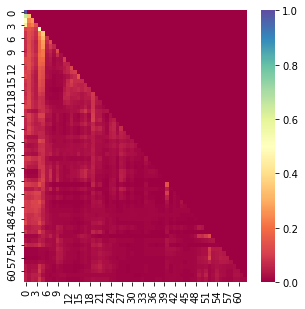

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(attn[0, :, :], ax=ax, cmap="Spectral")

In [6]:
def plot_attention_line(model, data_iter=dataset_test, base_df=base_loader.df[DataTypes.TEST], id=None, step=2, n_color=5, n_layer=0):
    if id is None:
        # randomize
        sample_size = len(data_iter)
        id = int(np.random.uniform(0, sample_size))
    
    attn = data_iter.get_attention(id=id, model=model).detach().cpu().numpy()[0, :, :, :]
    attn = attn / np.sum(attn)
    inst = dataset_test[id]['inst']

    # build df ----
    df_plot = pd.DataFrame({
        'prs': data_iter[id]['prs'][:, 0].squeeze().cpu().numpy(),
        'prs_lead': data_iter[id]['prs'][:, 1].squeeze().cpu().numpy(),
        'attn': np.flip(attn[n_layer, :, 0], axis=-1),
        't': data_iter[id]['time']
    })
    #df_plot['t'] = range(df_plot.shape[0])
    df_plot['date'] = base_df.index[df_plot['t']]
    df_plot['t_group'] = pd.qcut(df_plot['t'], int(63/step), labels=False)
    df_plot['attn_mean'] = df_plot['attn'].groupby(df_plot['t_group']).transform('mean')
    df_plot['attn_group'] = pd.qcut(df_plot['attn_mean'], n_color, labels=False)

    # plot ----
    fig, ax = plt.subplots(1,1)
    cmap = plt.get_cmap(name='viridis', lut=n_color)
    for i in range(0, 63+1, step):
        # ... in segments ----
        group = df_plot.iloc[i:(i+step+1),:]
        attn_i = group.iloc[0, -1]
        color = cmap(attn_i)
        ax.plot(group['date'], group['prs'], color=color, markeredgewidth=1.5, zorder=0, marker=".")
        ax.plot(group['date'], group['prs'], color=color, linewidth=2.5, zorder=2)

    # prediction point
    # ... currently not support business date (!)
    next_date = df_plot['date'].iat[-1] + pd.Timedelta(1, 'D')
    ax.scatter(next_date, df_plot['prs_lead'].iat[-1], marker="x", color="red")

    # raw
    ax2 = ax.twinx()
    ax2.plot(df_plot['date'], df_plot['attn'], '--', zorder=1, color="black")

    # labels, ..
    ax.set_xlabel('t')
    ax.set_ylabel('price')
    ax2.set_ylabel('attention')
    ax.set_title(inst)
    ax.tick_params(axis='x', rotation=70)
    fig.show()

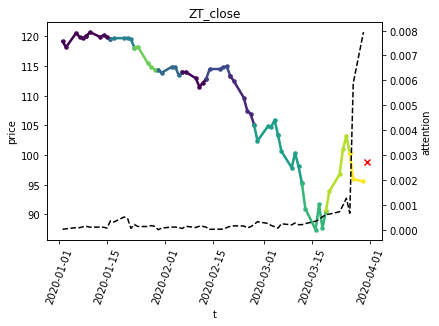

In [7]:
plot_attention_line(model=model, data_iter=dataset_test, step=5, n_color=10)

## Positional Attention (Global)

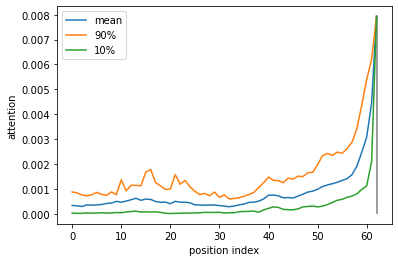

In [9]:
def calc_pos_attention(data_iter, model):
    attn_dict = {}

    for id in range(len(data_iter)):
        attn = data_iter.get_attention(id=id, model=model).detach().cpu().numpy()[0, :, :, :] # B x n_layer x T x T 
        attn = attn / np.sum(attn)

        # tmp: just look at last (& full) time window; first layer
        attn_last = attn[0, :, 0]

        attn_dict[id] = np.flip(attn_last, axis=-1)

    df = pd.DataFrame(attn_dict)
    return df

def plot_pos_attention(df):
    fig, ax = plt.subplots(1,1)
    ax.plot(range(df.shape[0]), df.mean(axis=1), label="mean")
    ax.plot(range(df.shape[0]), df.quantile(q=0.9, axis=1), label="90%")
    ax.plot(range(df.shape[0]), df.quantile(q=0.1,axis=1), label="10%")
    ax.vlines(df.shape[0]-1, ymin=0, ymax=np.max(df.mean(axis=1)), color="grey")
    #xlabels = {i: str(i - global_attn.shape[0]) for i in range(global_attn.shape[0]) if i % 5 == 0}
    #print(xlabels)
    #ax.set_xticks(xlabels.keys())
    #ax.set_xticklabels(xlabels.values())
    ax.legend()
    ax.set_ylabel("attention")
    ax.set_xlabel("position index")


pos_attention = calc_pos_attention(dataset_test, model)
plot_pos_attention(pos_attention)

## Regime identification Attention (Global)

In [15]:
data_iter = dataset_train
base_df = base_loader.df[DataTypes.TRAIN]

# ----

attn_dict = {}
for id in range(0, len(data_iter)):
    attn = data_iter.get_attention(id=id, model=model).detach().cpu().numpy()[0, :, :, :]
    attn = attn / np.sum(attn)
    inst = data_iter[id]['inst']
    ts = data_iter[id]['time'].detach().cpu().numpy()
    dates = base_df.index[ts]

    # tmp: just look at full window (last entry)
    attn_last = attn[0, :, 0]
    dates_last = dates[-1]

    if inst not in attn_dict:
        attn_dict[inst] = {}
    attn_dict[inst][dates_last] = attn_last

attn_touple = {(outerKey, innerKey): values for outerKey, innerDict in attn_dict.items() for innerKey, values in innerDict.items()}
df_attn = pd.DataFrame(attn_touple)
df_attn

AN_close                                                         \
   1990-03-29 1990-06-28 1990-09-25 1990-12-21 1991-03-22 1991-06-21   
0    0.007937   0.007937   0.007937   0.007937   0.007937   0.007937   
1    0.003417   0.002469   0.005630   0.005419   0.005448   0.001039   
2    0.000628   0.002018   0.004587   0.003981   0.004510   0.000643   
3    0.001119   0.001859   0.003758   0.001517   0.003099   0.000509   
4    0.000517   0.001784   0.003005   0.001386   0.002689   0.000454   
..        ...        ...        ...        ...        ...        ...   
58   0.000192   0.000295   0.000269   0.000167   0.000203   0.000597   
59   0.000079   0.000490   0.000241   0.000130   0.000282   0.000159   
60   0.000008   0.000757   0.000056   0.000116   0.000376   0.000014   
61   0.000003   0.000929   0.000083   0.000153   0.000414   0.000015   
62   0.000002   0.000844   0.000058   0.000177   0.000542   0.000011   

                                                   ...   ZZ_close             \
   1991-09-18    1991-12-16 1992-03-16 1992-06-15  ... 2011-09-20 2011-12-16   
0    0.007937  7.936508e-03   0.007937   0.007937  ...   0.007937   0.007937   
1    0.004707  3.360107e-03   0.004942   0.005937  ...   0.005902   0.005963   
2    0.003896  1.079343e-03   0.003754   0.005109  ...   0.002548   0.003677   
3    0.002719  1.247626e-03   0.003726   0.004612  ...   0.001264   0.003100   
4    0.002350  9.839725e-04   0.003621   0.004308  ...   0.001598   0.002489   
..        ...           ...        ...        ...  ...        ...        ...   
58   0.000450  3.968029e-05   0.000192   0.000361  ...   0.000231   0.000071   
59   0.000479  4.187768e-05   0.000081   0.000591  ...   0.000089   0.000180   
60   0.000798  1.305960e-05   0.000052   0.001206  ...   0.000081   0.000401   
61   0.000862  3.367317e-05   0.000053   0.001072  ...   0.000037   0.000409   
62   0.000795  5.150139e-07   0.000053   0.000450  ...   0.000024   0.000154   

                                                                         \
   2012-03-16 2012-06-13 2012-09-10 2012-12-06    2013-03-07 2013-06-04   
0    0.007937   0.007937   0.007937   0.007937  7.936508e-03   0.007937   
1    0.006352   0.006530   0.005326   0.002519  1.500590e-03   0.006059   
2    0.005821   0.004486   0.002132   0.002004  1.025557e-03   0.003661   
3    0.003726   0.002764   0.002289   0.001690  3.593319e-04   0.003357   
4    0.002951   0.002717   0.001965   0.001636  3.449616e-04   0.002950   
..        ...        ...        ...        ...           ...        ...   
58   0.000193   0.000135   0.000367   0.000195  2.288666e-04   0.000199   
59   0.000115   0.000183   0.000267   0.000303  8.973414e-05   0.000273   
60   0.000253   0.000056   0.000256   0.000446  1.127343e-04   0.000146   
61   0.000394   0.000106   0.000555   0.000488  1.691089e-05   0.000116   
62   0.000682   0.000028   0.000609   0.000451  1.600696e-08   0.000304   

                          
   2013-08-30 2013-11-27  
0    0.007937   0.007937  
1    0.002948   0.003936  
2    0.002568   0.002349  
3    0.001951   0.002084  
4    0.001679   0.001708  
..        ...        ...  
58   0.000088   0.000039  
59   0.000115   0.000023  
60   0.000173   0.000015  
61   0.000150   0.000014  
62   0.000204   0.000018  

[63 rows x 4382 columns]

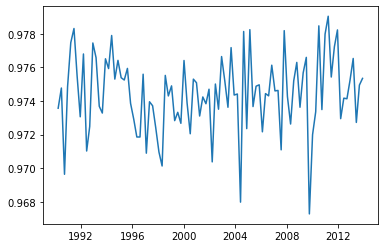

In [68]:
def calc_bhattacharyya_coef(p, q):
    return np.sum(np.sqrt(np.multiply(p, q)))

def calc_distance(p, q):
    return np.sqrt(1 - calc_bhattacharyya_coef(p, q))


tmp = df_attn
tmp = tmp.T
tmp = tmp.reset_index(drop=False) 
tmp = tmp.groupby('level_1').mean() # average across instruments

# calc distance per t ----
tmp_avg = tmp.mean(axis=0)
list = {}
for i, date in enumerate(tmp.index):
    # per t
    list[date] = calc_distance(tmp.iloc[i,:], tmp_avg)

plt.plot(list.keys(), list.values())

array([1, 8, 9])